fpr template O3
===============



## Common code blocks



In [1]:
OPT = "-O3"
TESTFILE = 'fpr_smallint_and_FFT_f_one_layer'

### Collect



In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import chipwhisperer as cw
import subprocess
from tqdm import trange, tnrange
from setup_generic import hardware_setup, scope_reset, tracewhisperer_husky_setup

TARGET = 'stm32f4'
SS_VER='SS_VER_1_1'

subprocess.run(["make", "-B", "TESTFILE=%s"%TESTFILE, "OPT=%s"%OPT, "build"])
subprocess.run(["bash", "saubere_lss.sh", "build-stm32f4/%s.lss"%TESTFILE, "%s%s.lss"%(TESTFILE, OPT)])

# Should reserve at least 1 cycle as margin to clip
INDEX_MARGIN = 1

In [1]:
PROGRAM = True
scope, target = hardware_setup(
        "build-%s/%s.hex"%(TARGET, TESTFILE), TARGET, SS_VER, PROGRAM)
scope_reset(scope, TARGET)
trace = tracewhisperer_husky_setup(scope, target)

# scope.clock
clkgen_freq0 = scope.clock.clkgen_freq  # 7363636.363636363
scope.clock.clkgen_freq = 30E6
# scope.clock.adc_mul = 4

# scope.gin
scope.gain.db = 12

# target.baud
tmp_target_baud = target.baud
target.baud = int(tmp_target_baud *
                  (scope.clock.clkgen_freq / clkgen_freq0))

In [1]:
def get_addr(text, cmd, addr_shift, addr_rel_start, addr_rel_end, match, scope, target, trace):
    trace.set_isync_matches(addr_shift + addr_rel_start, addr_shift + addr_rel_end, match=match)
    trace.arm_trace()
    scope.arm()
    target.simpleserial_write(cmd, text)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')
    # response = target.simpleserial_read('r', 1)
    # print(response)
    scope.get_last_trace()
    raw = trace.read_capture_data()
    times = trace.get_rule_match_times(raw, rawtimes=False, verbose=True)
    return times

### Analysis



In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import importlib
from sklearn.model_selection import train_test_split
from sca_preprocess import trace_categorize
from sca_preprocess import trace_fft, trace_butter_lpf
from sca_preprocess import calc_snr, calc_ttest, calc_sod
from sca_preprocess import select_poi_max_rank, select_poi_threshold
from TA_generative import template_build, template_attack, template_attack_report
from TA_discriminative import classifier_train, classifier_inference, classifier_report

MCU_freq = 30e6
adc_mul = 4
sample_freq = MCU_freq * adc_mul
cutoff_freq = sample_freq / 8

seed = 42
test_split = 0.5

In [1]:
def select_traces_accto_class(traces_dict, class_label_map):
    final_traces = []
    label = []
    for cls in range(len(class_label_map.keys())):
        N_trace = class_label_map[cls]['num_to_select']
        label_range = class_label_map[cls]['labels']
        traces_in_class = []
        for l in label_range:
            traces_in_class.append(traces_dict[l])
            # print(l, traces_in_class[-1].shape)
        combined = np.concatenate(traces_in_class, axis=0)  # ((1/2/4/8/16) x #trace, #sample)
        # (1/2/4/8/16) x #trace ⪭ #trace，random pick #trace from it
        selected_idx = np.random.choice(combined.shape[0], N_trace, replace=False)
        selected = combined[selected_idx]
        final_traces.append(selected)
        label += [cls] * N_trace
    traces = np.vstack(final_traces)  # shape (#class * #trace, #sample)
    label = np.array(label)  # (#class * #trace,)
    return traces, label

In [1]:
def select_and_split(traces_dict, class_label_map, start_idx, end_idx, test_split,
                     seed=seed, sample_freq=sample_freq, cutoff_freq=cutoff_freq):
    # select traces in class
    np.random.seed(seed)
    traces, label = select_traces_accto_class(traces_dict, class_label_map)
    traces = traces[:, start_idx:end_idx]
    traces_lpf = trace_butter_lpf(traces, sample_freq, cutoff_freq)
    # traces_dict = trace_categorize(traces, label)
    print(f"traces.shape: {traces.shape}")
    print(f"label.shape: {label.shape}")

    # train/test split
    traces_train, traces_test, label_train, label_test = \
        train_test_split(traces_lpf, label,
                         test_size=test_split,
                         stratify=label,
                         shuffle=True,
                         random_state=seed)
    print(f"traces_train.shape: {traces_train.shape}")
    print(f"traces_test.shape: {traces_test.shape}")

    return traces_train, traces_test, label_train, label_test

## fpr\_scaled



### Address & Cycles & Start/End Indices



In [1]:
def num_to_text(num):
    """
    Convert a number to a 12-byte string with leading zeros.
    """
    prefix = '000000000000'  # 12 zeros (
    if(num >= 0):
        text = (prefix+f"{num:02}"+f"{0:02}").encode('utf8')
    else:
        text = (prefix+f"{abs(num):02}"+f"{1:02}").encode('utf8')
    return text

The address shift in the whole executable, and relative start/end in `fpr.o` are



In [1]:
text = num_to_text(-31)
get_addr(text, 'l', 0x8000500, 0x00, 0x182, 0, scope, target, trace)
get_addr(text, 'l', 0x8000500, 0x00, 0x182, 1, scope, target, trace)

28 rule # 0, delta = 28
     149 rule # 0, delta = 149

     28 rule # 0, delta = 28
    149 rule # 0, delta = 149


| |start|end|diff|
|---|---|---|---|
| cycle|28|149|121|
| sample|112|596|484|



### Collect traces



In [1]:
start_idx = 28
end_idx = 149

In [1]:
N_trace_train = 512
N_trace_test = 1000
N_trace = N_trace_train + N_trace_test

In [1]:
N_sample = (end_idx + INDEX_MARGIN) * 4
N_sample_clip = (end_idx - start_idx) * 4
scope.adc.samples = N_sample
traces = []
labels = []

label_list = list(range(-31, 32))
for i in trange(len(label_list), desc='Capturing traces'):
    num = label_list[i]
    text = num_to_text(num)
    for j in range(N_trace):
        labels.append(num)
        scope.arm()
        target.simpleserial_write('l', text)
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition at', i, j)
            continue
        wave = scope.get_last_trace()
        traces.append(wave[start_idx*4:end_idx*4])  # (#sample,)

Cast to numpy.array and reshape:



In [1]:
traces = np.array(traces)  # (#class, #trace, #sample)
labels = np.array(labels)  # (#class, #trace)

traces = traces.reshape(-1, N_sample_clip)  # (#class x #trace, #sample)
labels = labels.flatten()                   # (#class x #trace,)

In [1]:
name = f'data{OPT}/profile/fpr_scaled'
np.save(name + '.npy', traces)
np.savetxt(name + '.csv', labels, delimiter=',', fmt='%d')

Since the start and end indices are of the following position:  

    0                                              (149+1)*4
    |--------|--- ..................... ------|------------|
          28*4                           149*4

And we impose a `N_sample_clip` to tighten the range, so the start/end position now becomes  


| |old start idx|old end idx|new start idx|new end pos|diff|
|---|---|---|---|---|---|
| cycle|28|149|0|121|121|



### Build template



In [1]:
N_trace_dict = {'train': 512, 'test': 1000}
N_trace = N_trace_dict['train'] + N_trace_dict['test']
test_split = N_trace_dict['test'] / N_trace

start_idx = 0
end_idx = 121

The "class-label" map in this task is



In [1]:
class_label_map_scaled = {
    0: {"num_to_select": N_trace,
        "labels": [0]},
    1: {"num_to_select": N_trace,
        "labels": [1]},
    2: {"num_to_select": N_trace,
        "labels": [-1]},
    3: {"num_to_select": N_trace,
        "labels": [2, 3]},
    4: {"num_to_select": N_trace,
        "labels": [-3, -2]},
    5: {"num_to_select": N_trace,
        "labels": [4, 5, 6, 7]},
    6: {"num_to_select": N_trace,
        "labels": [-7, -6, -5, -4]},
    7: {"num_to_select": N_trace,
        "labels": list(range(8, 16))},    # [8, ..., 15]
    8: {"num_to_select": N_trace,
        "labels": list(range(-15, -7))},  # [-15, ..., -8]
    9: {"num_to_select": N_trace,
        "labels": list(range(16, 23))},    # [16, ..., 22]
    10: {"num_to_select": N_trace,
        "labels": list(range(-22, -15))},  # [-22, ..., -16]
}
# N_class = len(class_label_map.keys())

In [1]:
name = f'data{OPT}/profile/fpr_scaled'
traces = np.load(name + '.npy')               # (#label x #trace, #sample)
label = np.loadtxt(name + '.csv', dtype=int)  # (#label x #trace,)
N_sample = traces.shape[1]
# N_trace = traces.shape[0]//N_label
traces_dict = trace_categorize(traces, label)

traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_scaled,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (16632, 484)
label.shape: (16632,)
traces_train.shape: (5632, 484)
traces_test.shape: (11000, 484)

In [1]:
score = calc_snr(traces_train_dict)
threshold = 0.95
poi = select_poi_threshold(score, threshold)
N_poi = len(poi)
template_shift = template_build(traces_train_dict, poi)
print(f"Selected #POI {len(poi)} with threshold {threshold}")
print(sorted(poi))

guess = template_attack(template, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 9.6493
Selected #POI 61 with threshold 0.95
[6, 7, 8, 9, 10, 11, 12, 13, 64, 210, 211, 212, 213, 214, 215, 216, 236, 237, 238, 245, 246, 247, 248, 300, 301, 302, 303, 304, 305, 306, 307, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 340, 341, 342, 343, 344, 345, 362, 363, 364, 365, 366, 436, 437, 438, 439, 440, 458, 459, 460, 461]
#Success: 10790
%Success: 98.09%
Error guess: [5, 9, 1, 5, 7, 8, 0, 7, 6, 10, 5, 1, 4, 7, 5, 5, 3, 10, 9, 5, 1, 7, 6, 5, 10, 5, 9, 5, 6, 6, 0, 5, 2, 5, 9, 5, 0, 4, 2, 5, 3, 2, 6, 5, 7, 9, 5, 5, 4, 6, 8, 2, 7, 5, 4, 5, 7, 10, 7, 3, 8, 7, 7, 4, 4, 1, 9, 7, 6, 5, 5, 1, 0, 6, 5, 3, 5, 2, 10, 8, 6, 3, 1, 7, 8, 6, 2, 4, 3, 0, 0, 5, 5, 10, 6, 5, 9, 7, 2, 5, 9, 8, 6, 5, 7, 1, 9, 5, 8, 3, 3, 7, 6, 6, 2, 5, 6, 0, 7, 7, 4, 1, 9, 1, 0, 1, 5, 10, 10, 7, 4, 2, 7, 5, 0, 3, 8, 1, 2, 2, 9, 1, 5, 7, 4, 7, 9, 4, 3, 4, 9, 5, 3, 5, 4, 5, 6, 4, 0, 9, 5, 10, 2, 7, 5, 7, 1, 5, 9, 5, 5, 9, 7, 10, 3, 5, 8, 2, 9, 4, 7, 9, 4, 3, 1, 1, 1, 0, 6, 5, 9, 9, 8, 2, 4, 1, 4, 7, 5, 

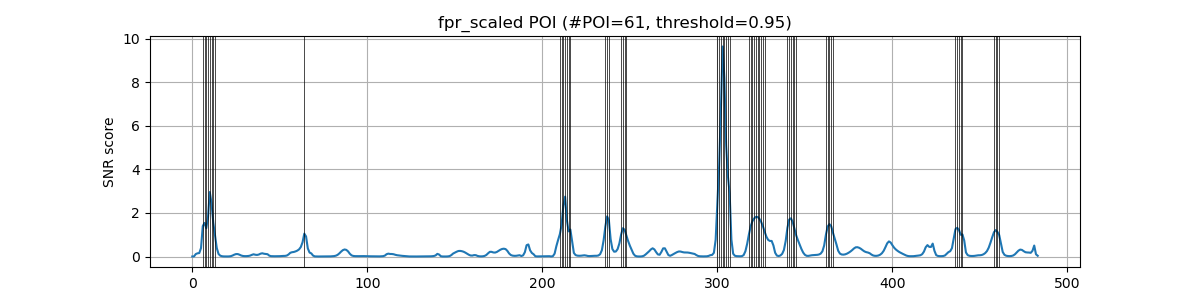

In [1]:
name = f'img{OPT}/profile/fpr_scaled_POI.png'
plt.figure(figsize=(12,3))
plt.plot(score)
for t in poi:
    plt.axvline(x=t, color='black', lw=0.5)
# plt.xlim(0, N_sample)
# plt.xticks(range(0, N_sample + 1, 500))
plt.ylabel('SNR score')
plt.title(f'fpr_scaled POI (#POI={N_poi}, threshold={threshold})')
plt.grid()
plt.savefig(name)
plt.close()
print(name)

In [1]:
class NaiveModel(nn.Module):
    def __init__(self, N_class):
        super().__init__()
        k = 5
        p = k // 2  # "same" padding
        N_channel = 1
        # CNN
        self.conv1 = nn.Conv1d(N_channel, 4, kernel_size=k, padding=p)
        self.bn1 = nn.BatchNorm1d(4)
        self.act = nn.Sigmoid()
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        # MLP
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, N_class)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_scaled.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                         list(range(N_sample)), model)
y_prob = classifier_test(traces_test, label_test, list(range(N_sample)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─BatchNorm1d: 1-2                       8
├─Sigmoid: 1-3                           --
├─AvgPool1d: 1-4                         --
├─LazyLinear: 1-5                        --
├─Linear: 1-6                            4,160
├─Linear: 1-7                            715
├─Dropout: 1-8                           --
├─ReLU: 1-9                              --
Total params: 4,907
Trainable params: 4,907
Non-trainable params: 0
Test set LOSS: 0.0014
Test set ACCURACY: 0.9996
Test set classification report
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      1000
           1   1.000000  1.000000  1.000000      1000
           2   1.000000  1.000000  1.000000      1000
           3   0.999001  1.000000  0.999500      1000
           4   1.000000  0.999000  0.999500      1000
           5   1.000

## fpr\_mul



### Address & Cycles & Start/End Indices



num ∈ [2, 31] ⋂ ZZ. You SHOULD use 'little' b.c. MCU uses little endian, but since 'num' only occupies 1 bytes, it doesn't matter that you left it as 'big', the default.  

Catastrophe happens when `length` ⪭ 2. Let `num=31` as an example. In this case, `num.to_bytes(2, 'little/big')` give you `b'\x1f\x00'` and `b'\x00\x1f'` resp.



In [1]:
def num_to_text(num):
    text = num.to_bytes(1, byteorder='little')
    return text

The address shift in the whole executable, and relative start/end in `fpr.o` are  

Total:



In [1]:
text = num_to_text(31)
get_addr(text, 'm', 0x800091c, 0x00, 0xe8, 0, scope, target, trace)
get_addr(text, 'm', 0x800091c, 0x00, 0xe8, 1, scope, target, trace)

32 rule # 0, delta = 32
     108 rule # 0, delta = 108

     32 rule # 0, delta = 32
    108 rule # 0, delta = 108

shift 55:



In [1]:
text = num_to_text(31)
get_addr(text, 'm', 0x800091c, 0x76, 0xbe, 0, scope, target, trace)
get_addr(text, 'm', 0x800091c, 0x76, 0xbe, 1, scope, target, trace)

73 rule # 0, delta = 73
      95 rule # 0, delta = 95

    73 rule # 0, delta = 73
    95 rule # 0, delta = 95

Multiply:



In [1]:
text = num_to_text(31)
get_addr(text, 'm', 0x800091c, 0x34, 0x70, 0, scope, target, trace)
get_addr(text, 'm', 0x800091c, 0x34, 0x70, 1, scope, target, trace)

54 rule # 0, delta = 54
      71 rule # 0, delta = 71

    54 rule # 0, delta = 54
    71 rule # 0, delta = 71

Summary:  


| |start idx|end idx|diff|
|---|---|---|---|
| Total|32|108|76|
| Shift 55|73|95|22|
| Multiply|54|71|17|



### Collect traces



Use the start/end indices from the last section:



In [1]:
start_idx = 32
end_idx = 108

In [1]:
N_trace_train = 1200
N_trace_test = 2400
N_trace = N_trace_train + N_trace_test

In [1]:
N_sample = (end_idx + INDEX_MARGIN) * 4
N_sample_clip = (end_idx - start_idx) * 4
scope.adc.samples = N_sample
traces = []
labels = []

label_list = list(range(2, 32))
for i in trange(len(label_list), desc='Capturing traces'):
    num = label_list[i]
    text = num_to_text(num)
    for j in range(N_trace):
        labels.append(num)
        scope.arm()
        target.simpleserial_write('m', text)
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition at', i, j)
            continue
        wave = scope.get_last_trace()
        traces.append(wave[start_idx*4:end_idx*4])  # (#sample,)

Cast to numpy.array and reshape:



In [1]:
traces = np.array(traces)  # (#class, #trace, #sample)
labels = np.array(labels)  # (#class, #trace)

traces = traces.reshape(-1, N_sample_clip)  # (#class x #trace, #sample)
labels = labels.flatten()                   # (#class x #trace,)

In [1]:
name = f'data{OPT}/profile/fpr_mul'
np.save(name + '.npy', traces)
np.savetxt(name + '.csv', labels, delimiter=',', fmt='%d')
print(name, "saved.")

Since the start and end indices are of the following position:  

    0                                              (108+1)*4
    |--------|--- ..................... ------|------------|
          32*4                            108*4

And we impose a `N_sample_clip` to tighten the range, so the start/end position now becomes  


| |old start idx|old end idx|new start idx|new end pos|diff|
|---|---|---|---|---|---|
| Total|32|108|0|76|76|
| Shift 55|73|94|41|63|22|
| Multiply|54|71|22|39|17|



### Build template



In [1]:
N_trace_dict = {'train': 1200, 'test': 2400}
N_trace = N_trace_dict['train'] + N_trace_dict['test']
test_split = N_trace_dict['test'] / N_trace

In [1]:
name = f'data{OPT}/profile/fpr_mul'
traces = np.load(name + '.npy')               # (#label x #trace, #sample)
label = np.loadtxt(name + '.csv', dtype=int)  # (#label x #trace,)
N_sample = traces.shape[1]
traces_dict = trace_categorize(traces, label)

print(traces.shape)
print(label.shape)

(108000, 304)
(108000,)

In [1]:
class NaiveModel(nn.Module):
    def __init__(self, N_class):
        super().__init__()
        k = 5
        p = k // 2  # "same" padding
        N_channel = 1
        # CNN
        self.conv1 = nn.Conv1d(N_channel, 4, kernel_size=k, padding=p)
        self.conv2 = nn.Conv1d(4, 4, kernel_size=k, padding=p)
        self.bn1 = nn.BatchNorm1d(4)
        self.bn2 = nn.BatchNorm1d(4)
        self.act = nn.Sigmoid()
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        # MLP
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, N_class)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [1]:
class AdaptiveResNet(nn.Module):
    def __init__(self, N_class):
        super(AdaptiveResNet, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)

        # Residual blocks
        self.layer1 = self._make_layer(64, 128, blocks=3, stride=2)
        self.layer2 = self._make_layer(128, 256, blocks=3, stride=2)
        self.layer3 = self._make_layer(256, 512, blocks=3, stride=2)

        # Adaptive pooling and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, N_class)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [Bottleneck(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(Bottleneck(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x = x.transpose(2, 1)  # (B, seq_len, C) -> (B, C, seq_len)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.global_pool(x).view(b, c)         # Squeeze: (B, C)
        y = self.fc(y).view(b, c, 1)               # Excitation: (B, C, 1)
        return x * y                               # Scale: channel-wise multiplication


class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels, reduction=reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        x = self.bn1(self.conv1(x))
        x = self.relu(x)

        x = self.bn2(self.conv2(x))
        x = self.relu(x)

        x = self.bn3(self.conv3(x))
        x = self.se(x)
        x += self.shortcut(identity)
        x = self.relu(x)

        return x

#### shift 55



In [1]:
start_idx = 41
end_idx = 63

# Here, '* 14' just because class 0 has 14 elements
class_label_map_shift = {
    0: {"num_to_select": N_trace * 14,
        "labels":  # make zu<2^55
        [2, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22]},
    1: {"num_to_select": N_trace * 14,
        "labels":  # make zu>=2^55
        [3, 6, 7, 12, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 31]},
}
# N_class = len(class_label_map_shift.keys())

for k, v in class_label_map_shift.items():
    print(f"id {k}:", v['num_to_select'], v['labels'])

id 0: 50400 [2, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22]
id 1: 50400 [3, 6, 7, 12, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [1]:
traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_shift,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (100800, 88)
label.shape: (100800,)
traces_train.shape: (33600, 88)
traces_test.shape: (67200, 88)

In [1]:
# N_poi = 30
# poi_space = 1
# score = calc_ttest(traces_train_dict)
# poi = select_poi_max_rank(score, N_poi, poi_space)

score = calc_snr(traces_train_dict)
threshold = 0.0193
poi = select_poi_threshold(score, threshold)
N_poi = len(poi)
template_shift = template_build(traces_train_dict, poi)
print(f"Selected #POI {N_poi} with threshold {threshold}")
print(sorted(poi))

guess = template_attack(template_shift, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 0.0858
Selected #POI 11 with threshold 0.0193
[6, 7, 14, 15, 16, 17, 18, 19, 20, 21, 22]
#Success: 53016
%Success: 78.89%
Error guess: [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 

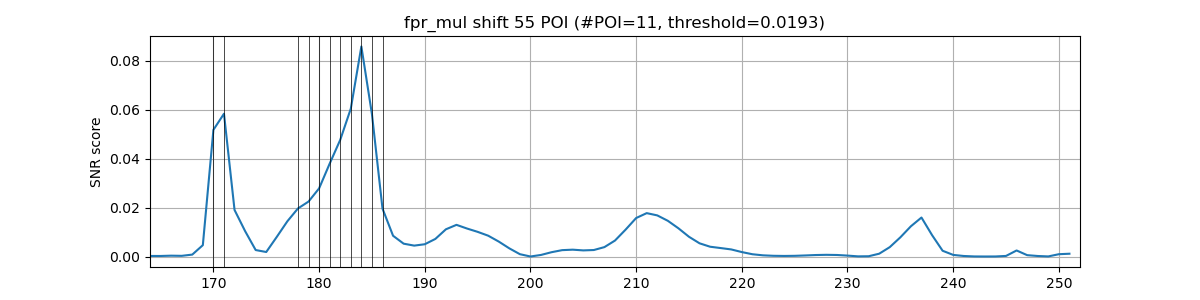

In [1]:
name = f'img{OPT}/profile/fpr_mul_shift55_POI.png'
plt.figure(figsize=(12,3))
idx = np.arange(start_idx * 4, end_idx * 4)
plt.plot(idx, score)
plt.plot(score)
for t in [i + start_idx * 4 for i in poi]:
    plt.axvline(x=t, color='black', lw=0.5)
plt.xlim(start_idx * 4, end_idx * 4)
# plt.xticks(np.arange(start_idx * 4, end_idx * 4 + 1, 50))
plt.ylabel('SNR score')
plt.title(f'fpr_mul shift 55 POI (#POI={N_poi}, threshold={threshold})')
plt.grid()
plt.savefig(name)
plt.close()
print(name)

In [1]:
np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_shift.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                                 list(range((end_idx - start_idx) * 4)),
                                 model, num_epochs=100)
y_prob = classifier_test(traces_test, label_test,
                         list(range((end_idx - start_idx) * 4)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─Conv1d: 1-2                            84
├─BatchNorm1d: 1-3                       8
├─BatchNorm1d: 1-4                       8
├─Sigmoid: 1-5                           --
├─AvgPool1d: 1-6                         --
├─LazyLinear: 1-7                        --
├─Linear: 1-8                            16,512
├─Linear: 1-9                            258
├─Dropout: 1-10                          --
├─ReLU: 1-11                             --
Total params: 16,894
Trainable params: 16,894
Non-trainable params: 0
Epoch 59 | train loss 0.1761 acc 0.9276 | val loss 0.2246 acc 0.9113
Early stopping triggered.
Test set LOSS: 0.2242
Test set ACCURACY: 0.9078
Test set classification report
              precision    recall  f1-score   support

           0   0.907401  0.908185  0.907793     33600
           1   0.908105  0.907321  0.907713     336

#### Multiply



In [1]:
start_idx = 22
end_idx = 39

class_label_map_4_5 = {
    0: {"num_to_select": N_trace, "labels": [4]},
    1: {"num_to_select": N_trace, "labels": [5]},
}
class_label_map_6_7 = {
    0: {"num_to_select": N_trace, "labels": [6]},
    1: {"num_to_select": N_trace, "labels": [7]},
}
class_label_map_8_11 = {
    0: {"num_to_select": N_trace, "labels": [8]},
    1: {"num_to_select": N_trace, "labels": [9]},
    2: {"num_to_select": N_trace, "labels": [10]},
    3: {"num_to_select": N_trace, "labels": [11]},
}
class_label_map_12_15 = {
    0: {"num_to_select": N_trace, "labels": [12]},
    1: {"num_to_select": N_trace, "labels": [13]},
    2: {"num_to_select": N_trace, "labels": [14]},
    3: {"num_to_select": N_trace, "labels": [15]},
}
class_label_map_16_22 = {
    0: {"num_to_select": N_trace, "labels": [16]},
    1: {"num_to_select": N_trace, "labels": [17]},
    2: {"num_to_select": N_trace, "labels": [18]},
    3: {"num_to_select": N_trace, "labels": [19]},
    4: {"num_to_select": N_trace, "labels": [20]},
    5: {"num_to_select": N_trace, "labels": [21]},
    6: {"num_to_select": N_trace, "labels": [22]},
}

fig, axs = plt.subplots(5, 1, figsize=(12, 10))
name = f'img{OPT}/profile/fpr_mul_multiply_POI.png'
idx = np.arange(start_idx * 4, end_idx * 4)
xticks = range(start_idx * 4, end_idx * 4 + 1, 6)

##### Multiply [4, 5]



In [1]:
traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_4_5,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (7200, 68)
label.shape: (7200,)
traces_train.shape: (2400, 68)
traces_test.shape: (4800, 68)

In [1]:
score_4_5 = calc_snr(traces_train_dict)
threshold = 0.175
poi_4_5 = select_poi_threshold(score_4_5, threshold)
N_poi = len(poi_4_5)
template_4_5 = template_build(traces_train_dict, poi_4_5)
print(f"Selected #POI {N_poi} with threshold {threshold}")
print(sorted(poi_4_5))

guess = template_attack(template_4_5, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 1.1552
Selected #POI 21 with threshold 0.175
[6, 7, 8, 9, 10, 11, 12, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 59, 60, 61, 62]
#Success: 4736
%Success: 98.67%
Error guess: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Counter: Counter({0: 49, 1: 15})

In [1]:
axs[0].plot(idx, score_4_5)
for t in [i + start_idx * 4 for i in poi_4_5]:
    axs[0].axvline(x=t, color='black', lw=0.5)
axs[0].set_xlim(start_idx * 4, end_idx * 4)
axs[0].set_xticks(xticks)
axs[0].set_ylabel('t-test score')
axs[0].set_title(f'fpr_mul multiply [4, 5] POI (#POI={N_poi}, threshold={threshold})')
axs[0].grid()

In [1]:
np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_4_5.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                                 list(range((end_idx - start_idx) * 4)),
                                 model, num_epochs=100)
classifier_test(traces_test, label_test,
                list(range((end_idx - start_idx) * 4)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─Conv1d: 1-2                            84
├─BatchNorm1d: 1-3                       8
├─BatchNorm1d: 1-4                       8
├─Sigmoid: 1-5                           --
├─AvgPool1d: 1-6                         --
├─LazyLinear: 1-7                        --
├─Linear: 1-8                            16,512
├─Linear: 1-9                            258
├─Dropout: 1-10                          --
├─ReLU: 1-11                             --
Total params: 16,894
Trainable params: 16,894
Non-trainable params: 0
Epoch 66 | train loss 0.0010 acc 0.9995 | val loss 0.0005 acc 1.0000
Early stopping triggered.
Test set LOSS: 0.0044
Test set ACCURACY: 0.9981
Test set classification report
              precision    recall  f1-score   support

           0   1.000000  0.996250  0.998121      2400
           1   0.996264  1.000000  0.998129      24

##### Multiply [6, 7]



In [1]:
traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_6_7,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (7200, 68)
label.shape: (7200,)
traces_train.shape: (2400, 68)
traces_test.shape: (4800, 68)

In [1]:
score_6_7 = calc_snr(traces_train_dict)
threshold = 0.03
poi_6_7 = select_poi_threshold(score_6_7, threshold)
N_poi = len(poi_6_7)
template_6_7 = template_build(traces_train_dict, poi_6_7)
print(f"Selected #POI {N_poi} with threshold {threshold}")
print(sorted(poi_6_7))

guess = template_attack(template_6_7, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 0.2625
Selected #POI 22 with threshold 0.03
[6, 7, 8, 9, 10, 11, 12, 13, 29, 30, 31, 32, 33, 34, 58, 59, 60, 61, 62, 63, 64, 65]
#Success: 4288
%Success: 89.33%
Error guess: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 

In [1]:
axs[1].plot(idx, score_6_7)
for t in [i + start_idx * 4 for i in poi_6_7]:
    axs[1].axvline(x=t, color='black', lw=0.5)
axs[1].set_xlim(start_idx * 4, end_idx * 4)
axs[1].set_xticks(xticks)
axs[1].set_ylabel('t-test score')
axs[1].set_title(f'fpr_mul multiply [6, 7] POI (#POI={N_poi}, threshold={threshold})')
axs[1].grid()

In [1]:
np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_6_7.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                                 list(range((end_idx - start_idx) * 4)),
                                 model, num_epochs=100)
classifier_test(traces_test, label_test,
                list(range((end_idx - start_idx) * 4)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─Conv1d: 1-2                            84
├─BatchNorm1d: 1-3                       8
├─BatchNorm1d: 1-4                       8
├─Sigmoid: 1-5                           --
├─AvgPool1d: 1-6                         --
├─LazyLinear: 1-7                        --
├─Linear: 1-8                            16,512
├─Linear: 1-9                            258
├─Dropout: 1-10                          --
├─ReLU: 1-11                             --
Total params: 16,894
Trainable params: 16,894
Non-trainable params: 0
Epoch 53 | train loss 0.1189 acc 0.9579 | val loss 0.1313 acc 0.9500
Early stopping triggered.
Test set LOSS: 0.2036
Test set ACCURACY: 0.9252
Test set classification report
              precision    recall  f1-score   support

           0   0.917041  0.935000  0.925934      2400
           1   0.933702  0.915417  0.924469      24

##### Multiply [8, 11]



In [1]:
traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_8_11,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (14400, 68)
label.shape: (14400,)
traces_train.shape: (4800, 68)
traces_test.shape: (9600, 68)

In [1]:
score_8_11 = calc_snr(traces_train_dict)
threshold = 0.08
poi_8_11 = select_poi_threshold(score_8_11, threshold)
N_poi = len(poi_8_11)
template_8_11 = template_build(traces_train_dict, poi_8_11)
print(f"Selected #POI {N_poi} with threshold {threshold}")
print(sorted(poi_8_11))

guess = template_attack(template_8_11, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 0.6291
Selected #POI 24 with threshold 0.08
[6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 58, 59, 60, 61, 62, 65]
#Success: 7209
%Success: 75.09%
Error guess: [0, 3, 1, 2, 0, 1, 3, 3, 3, 2, 3, 0, 3, 1, 2, 2, 0, 3, 3, 0, 0, 2, 0, 0, 0, 3, 3, 2, 3, 0, 0, 1, 3, 1, 2, 0, 0, 1, 0, 2, 0, 0, 3, 3, 1, 3, 0, 3, 0, 1, 0, 1, 2, 3, 1, 3, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 3, 0, 3, 2, 3, 1, 3, 3, 3, 0, 0, 3, 0, 2, 3, 0, 3, 3, 3, 2, 0, 0, 3, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 0, 3, 3, 0, 2, 3, 0, 0, 2, 0, 3, 0, 1, 3, 3, 3, 0, 1, 3, 3, 1, 3, 0, 1, 1, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 2, 0, 0, 1, 3, 1, 1, 2, 1, 3, 2, 0, 0, 0, 3, 0, 0, 3, 0, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 3, 0, 3, 1, 0, 3, 3, 2, 0, 3, 0, 0, 1, 3, 1, 0, 1, 0, 0, 2, 0, 1, 0, 2, 3, 3, 0, 3, 3, 2, 2, 1, 3, 3, 0, 3, 0, 1, 2, 3, 3, 0, 0, 0, 2, 0, 0, 3, 3, 1, 3, 0, 0, 1, 0, 3, 0, 2, 1, 0, 0, 3, 3, 3, 2, 3, 0, 0, 2, 3, 3, 0, 3, 3, 1, 0, 3, 3, 0, 1, 2, 1, 2, 1, 3, 0, 1

In [1]:
axs[2].plot(idx, score_8_11)
for t in [i + start_idx * 4 for i in poi_8_11]:
    axs[2].axvline(x=t, color='black', lw=0.5)
axs[2].set_xlim(start_idx * 4, end_idx * 4)
axs[2].set_xticks(xticks)
axs[2].set_ylabel('t-test score')
axs[2].set_title(f'fpr_mul multiply [8, 11] POI (#POI={N_poi}, threshold={threshold})')
axs[2].grid()

In [1]:
np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_8_11.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                                 list(range((end_idx - start_idx) * 4)),
                                 model, num_epochs=200)
classifier_test(traces_test, label_test,
                list(range((end_idx - start_idx) * 4)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─Conv1d: 1-2                            84
├─BatchNorm1d: 1-3                       8
├─BatchNorm1d: 1-4                       8
├─Sigmoid: 1-5                           --
├─AvgPool1d: 1-6                         --
├─LazyLinear: 1-7                        --
├─Linear: 1-8                            16,512
├─Linear: 1-9                            258
├─Dropout: 1-10                          --
├─ReLU: 1-11                             --
Total params: 16,894
Trainable params: 16,894
Non-trainable params: 0
Epoch 139 | train loss 0.1977 acc 0.9259 | val loss 0.4557 acc 0.8229
Early stopping triggered.
Test set LOSS: 0.3552
Test set ACCURACY: 0.8612
Test set classification report
              precision    recall  f1-score   support

           0   0.814389  0.797083  0.805643      2400
           1   0.891479  0.924167  0.907529      2

##### Multiply [12, 15]



In [1]:
traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_12_15,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (14400, 68)
label.shape: (14400,)
traces_train.shape: (4800, 68)
traces_test.shape: (9600, 68)

In [1]:
score_12_15 = calc_snr(traces_train_dict)
threshold = 0.19
poi_12_15 = select_poi_threshold(score_12_15, threshold)
N_poi = len(poi_12_15)
template_12_15 = template_build(traces_train_dict, poi_12_15)
print(f"Selected #POI {N_poi} with threshold {threshold}")
print(sorted(poi_12_15))

guess = template_attack(template_12_15, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 1.5085
Selected #POI 21 with threshold 0.19
[6, 7, 9, 10, 11, 12, 27, 28, 29, 30, 31, 32, 33, 34, 59, 60, 61, 62, 63, 64, 65]
#Success: 8198
%Success: 85.40%
Error guess: [2, 0, 3, 0, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 0, 2, 0, 1, 1, 0, 0, 2, 3, 2, 3, 3, 0, 2, 0, 2, 2, 1, 1, 3, 3, 2, 0, 0, 2, 2, 1, 0, 2, 2, 1, 1, 2, 3, 0, 1, 1, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 1, 3, 1, 1, 3, 1, 0, 0, 2, 3, 1, 0, 3, 3, 2, 3, 2, 2, 1, 0, 2, 1, 3, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2, 0, 1, 2, 2, 2, 0, 0, 3, 1, 2, 0, 0, 0, 3, 0, 2, 0, 0, 2, 0, 0, 2, 3, 3, 2, 2, 2, 0, 2, 1, 2, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 1, 2, 2, 3, 1, 2, 0, 1, 0, 3, 0, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 3, 0, 0, 0, 2, 3, 1, 2, 3, 2, 2, 3, 1, 0, 0, 3, 3, 1, 0, 0, 0, 3, 2, 0, 1, 1, 1, 3, 2, 0, 0, 1, 1, 2, 3, 3, 0, 3, 1, 2, 2, 2, 1, 0, 2, 1, 3, 2, 3, 3, 3, 2, 2, 0, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 3, 3, 1, 3, 0, 1, 0, 2, 2, 1, 2, 0, 3, 2, 3, 2, 2, 2, 

In [1]:
axs[3].plot(idx, score_12_15)
for t in [i + start_idx * 4 for i in poi_12_15]:
    axs[3].axvline(x=t, color='black', lw=0.5)
axs[3].set_xlim(start_idx * 4, end_idx * 4)
axs[3].set_xticks(xticks)
axs[3].set_ylabel('t-test score')
axs[3].set_title(f'fpr_mul multiply [12, 15] POI (#POI={N_poi}, threshold={threshold})')
axs[3].grid()

In [1]:
np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_12_15.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                                 list(range((end_idx - start_idx) * 4)),
                                 model, num_epochs=100)
classifier_test(traces_test, label_test,
                list(range((end_idx - start_idx) * 4)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─Conv1d: 1-2                            84
├─BatchNorm1d: 1-3                       8
├─BatchNorm1d: 1-4                       8
├─Sigmoid: 1-5                           --
├─AvgPool1d: 1-6                         --
├─LazyLinear: 1-7                        --
├─Linear: 1-8                            16,512
├─Linear: 1-9                            516
├─Dropout: 1-10                          --
├─ReLU: 1-11                             --
Total params: 17,152
Trainable params: 17,152
Non-trainable params: 0
Epoch 77 | train loss 0.1152 acc 0.9588 | val loss 0.1272 acc 0.9417
Early stopping triggered.
Test set LOSS: 0.2015
Test set ACCURACY: 0.9223
Test set classification report
              precision    recall  f1-score   support

           0   0.925661  0.918333  0.921983      2400
           1   0.918975  0.926250  0.922598      24

##### Multiply [16, 22]



In [1]:
traces_train, traces_test, label_train, label_test = \
    select_and_split(traces_dict, class_label_map_16_22,
                     start_idx * 4, end_idx * 4, test_split)
traces_train_dict = trace_categorize(traces_train, label_train)

traces.shape: (25200, 68)
label.shape: (25200,)
traces_train.shape: (8400, 68)
traces_test.shape: (16800, 68)

In [1]:
score_16_22 = calc_snr(traces_train_dict)
threshold = 0.06
poi_16_22 = select_poi_threshold(score_16_22, threshold)
N_poi = len(poi_16_22)
template_16_22 = template_build(traces_train_dict, poi_16_22)
print(f"Selected #POI {N_poi} with threshold {threshold}")
print(sorted(poi_16_22))

guess = template_attack(template_16_22, traces_test, label_test)
template_attack_report(guess, label_test)

Max SNR: 0.4563
Selected #POI 25 with threshold 0.06
[6, 7, 8, 9, 10, 11, 12, 13, 27, 28, 29, 30, 31, 32, 33, 34, 35, 58, 59, 60, 61, 62, 63, 64, 65]
#Success: 8791
%Success: 52.33%
Error guess: [1, 0, 2, 2, 4, 3, 3, 5, 5, 5, 3, 1, 3, 4, 2, 2, 3, 6, 2, 6, 1, 2, 6, 2, 5, 3, 4, 0, 3, 3, 0, 6, 4, 5, 4, 0, 2, 0, 6, 2, 5, 5, 2, 6, 5, 0, 1, 3, 6, 1, 1, 1, 2, 1, 3, 0, 3, 3, 5, 3, 3, 2, 2, 4, 6, 3, 5, 3, 3, 5, 3, 5, 5, 5, 6, 3, 3, 1, 4, 1, 0, 5, 6, 4, 5, 0, 6, 3, 6, 5, 0, 5, 3, 3, 5, 3, 6, 6, 3, 2, 3, 3, 3, 5, 6, 3, 1, 5, 3, 3, 5, 6, 2, 1, 1, 5, 4, 5, 5, 1, 5, 3, 3, 5, 5, 3, 3, 2, 0, 0, 5, 2, 2, 3, 6, 3, 3, 1, 6, 3, 6, 1, 5, 3, 3, 6, 5, 2, 6, 1, 0, 2, 3, 6, 1, 3, 2, 5, 2, 4, 5, 3, 3, 5, 0, 6, 0, 6, 5, 1, 5, 0, 6, 5, 1, 1, 3, 3, 4, 4, 6, 6, 6, 5, 3, 2, 1, 5, 6, 2, 1, 3, 1, 2, 1, 5, 2, 3, 3, 3, 5, 5, 3, 6, 1, 5, 3, 6, 2, 3, 5, 5, 6, 2, 5, 0, 3, 3, 5, 2, 2, 5, 0, 3, 6, 3, 2, 3, 3, 5, 3, 3, 1, 0, 0, 4, 2, 3, 6, 3, 3, 5, 2, 5, 5, 1, 0, 6, 4, 5, 5, 5, 2, 3, 5, 5, 5, 3, 3, 3, 1, 3, 2, 5, 5, 3, 6, 3, 

In [1]:
axs[4].plot(idx, score_16_22)
for t in [i + start_idx * 4 for i in poi_16_22]:
    axs[4].axvline(x=t, color='black', lw=0.5)
axs[4].set_xlim(start_idx * 4, end_idx * 4)
axs[4].set_xticks(xticks)
axs[4].set_ylabel('t-test score')
axs[4].set_title(f'fpr_mul multiply [16, 22] POI (#POI={N_poi}, threshold={threshold})')
axs[4].grid()

In [1]:
np.random.seed(seed)
torch.manual_seed(seed)
N_class = len(class_label_map_16_22.keys())
model = NaiveModel(N_class)
model, scaler = classifier_train(traces_train, label_train,\
                                 list(range((end_idx - start_idx) * 4)),
                                 model, num_epochs=200)
classifier_test(traces_test, label_test,
                list(range((end_idx - start_idx) * 4)), model, scaler)

#+begin_example
Layer (type:depth-idx)                   Param #
NaiveModel                               --
├─Conv1d: 1-1                            24
├─Conv1d: 1-2                            84
├─BatchNorm1d: 1-3                       8
├─BatchNorm1d: 1-4                       8
├─Sigmoid: 1-5                           --
├─AvgPool1d: 1-6                         --
├─LazyLinear: 1-7                        --
├─Linear: 1-8                            16,512
├─Linear: 1-9                            903
├─Dropout: 1-10                          --
├─ReLU: 1-11                             --
Total params: 17,539
Trainable params: 17,539
Non-trainable params: 0
Epoch 100 | train loss 0.6653 acc 0.7311 | val loss 0.8480 acc 0.6607
Early stopping triggered.
Test set LOSS: 0.8094
Test set ACCURACY: 0.6781
Test set classification report
              precision    recall  f1-score   support

           0   0.767145  0.825000  0.795021      2400
           1   0.639163  0.674583  0.656396      2

##### Save figure



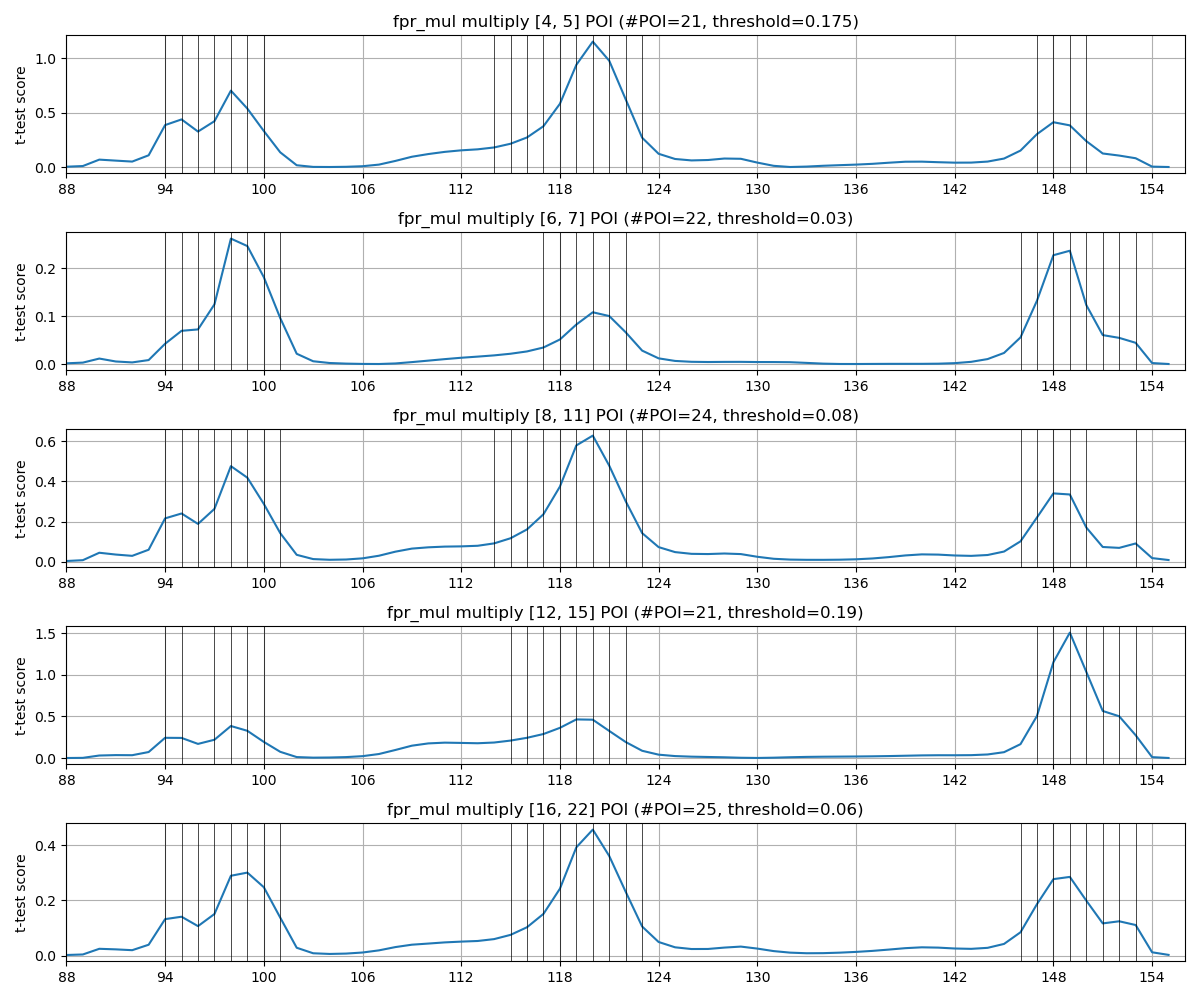

In [1]:
plt.tight_layout()
plt.savefig(name)
plt.close()
print(name)

## Together



Because O3 (or just some higher optimization level) can easily distort the assembly, it's not a good idea to measure `fpr_scaled` and `fpr_mul` with `do_fpr_scaled` & `do_fpr_mul` resp (in O0 you can still do so).

